In [1]:
from imports import *

2023-01-06 09:43:16.552463: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [42]:
import data_management
from data_management import load_stack
from data_management import load_data

import interactive_plot

import metrics
from metrics import statistics
from metrics import confusion_matrix
from metrics import error_distribution
from metrics import error_borders
from metrics import PR_curve

import generator_extended

import unet
from unet import load_model_unet
from unet import predict_net
from unet import get_unet
from unet import train
from unet import execute_predict

In [43]:

DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification/'
images_file = os.path.join(DATAPATH, 'images_cropped.npy')
labels_file = os.path.join(DATAPATH, 'labels_cropped.npy')

In [44]:
images = np.load(images_file)
labels = np.load(labels_file)

In [45]:
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [46]:
p = np.random.permutation(len(images))

In [47]:
images = images[p]
labels = labels[p]

In [48]:
labels = labels.astype(np.float)

In [49]:
images = images.astype(np.float)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [50]:
imgs_train = images[0:450]
imgs_mask_train = labels[0:450]
imgs_test = images[450:]
imgs_mask_test = labels[450:]

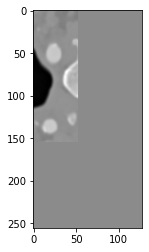

In [51]:
plt.imshow(imgs_train[30],cmap='gray')

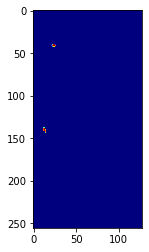

In [52]:
plt.imshow(imgs_mask_train[30],cmap='jet')

In [53]:
imgs_train.shape

(450, 256, 128, 1)

In [54]:
model = get_unet(0.0001, imgs_train.shape[1], imgs_train.shape[2], dr_rate=0.2, diceloss=False, jaccardloss=True, 
                 focalloss=False, customloss=False, start_filters=16)

start_filters 16
conv1 shape: (None, 256, 128, 16)
conv1 shape: (None, 256, 128, 16)
pool1 shape: (None, 128, 64, 16)
conv2 shape: (None, 128, 64, 32)
conv2 shape: (None, 128, 64, 32)
pool2 shape: (None, 64, 32, 32)
conv3 shape: (None, 64, 32, 64)
conv3 shape: (None, 64, 32, 64)
pool3 shape: (None, 32, 16, 64)
using jaccard loss!


In [55]:
train(model, imgs_train, imgs_mask_train, imgs_test, imgs_mask_test,
      '/tmp/models/A100test', 50, 1000, verbosity=1, 
      perform_flipping=True, perform_rotation=True, to_dir=False, train_on_borders=False)


-------------------------------
data details:
imgs_train.shape (450, 256, 128, 1)
imgs_mask_train.shape (450, 256, 128, 1)
imgs_test.shape (53, 256, 128, 1)
imgs_mask_test.shape (53, 256, 128, 1)
imgs_train.dtype float64
imgs_mask_train.dtype float64
imgs_test.dtype float64
imgs_mask_test.dtype float64
balance:
train_total_px 14745600
train_labeled_positive 27903
train_fraction_positive 0.0018922932942708334
min, max train 0.0 1.0
train_total_px 14745600 number 0/1 in mask 14745600
test_total_px 1736704
test_labeled_positive 2658
test_fraction_positive 0.0015304853331367925
min, max test 0.0 1.0
loading data done
saving model checkpoints in /tmp/models/A100test/
saving logfile in  /tmp/models/A100test/log.txt
augmenting on the fly...
computing statistics...
<generator object train.<locals>.combine_generator at 0x7ffa6c282cf0>
starting...
Epoch 1/1000


2023-01-06 10:13:03.522217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-06 10:13:03.541172: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz
2023-01-06 10:13:18.984059: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-01-06 10:13:19.601581: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-01-06 10:13:20.311666: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-01-06 10:13:20.311692: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-01-06 10:13:20.311758: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modif

InvalidArgumentError:  ConcatOp : Dimensions of inputs should match: shape[0] = [50,128,64,64] vs. shape[1] = [50,128,32,16]
	 [[node model_5/concatenate_27/concat (defined at home/daniel.haehn/miniconda3/envs/O/lib/python3.9/site-packages/keras/backend.py:3063) ]] [Op:__inference_train_function_7371]

Errors may have originated from an input operation.
Input Source operations connected to node model_5/concatenate_27/concat:
 model_5/dropout_16/dropout/Mul_1 (defined at home/daniel.haehn/miniconda3/envs/O/lib/python3.9/site-packages/keras/layers/core.py:208)	
 model_5/conv2d_181/Relu (defined at home/daniel.haehn/miniconda3/envs/O/lib/python3.9/site-packages/keras/backend.py:4700)

Function call stack:
train_function


### Evaluate

In [12]:
pred = execute_predict(model, imgs_test, stepsize=512, resize_shortest=True, extensive=False)

In [ ]:
np.save('predictions.npy', pred)

In [13]:
cmatrix = confusion_matrix(pred, imgs_mask_test)

In [14]:
statistics(cmatrix)

{'jaccard_foreground': 0.0,
 'jaccard_background': 0.9996920171773659,
 'voc_score': 0.49984600858868294,
 'accuracy': 0.9996920171773659,
 'precision': nan,
 'recall': 0.0}

In [ ]:
error_distribution(model, imgs_test, imgs_mask_test, extensive=True, figsize=(15,10))

In [ ]:
PR_curve(pred, imgs_mask_test)

### Results On Single Image

In [ ]:
use_train = False
imgnr = 60
input_img = cv2.imread('/n/regal/pfister_lab/vincent/vcasser/connectomics/movements/epfl-' + ('train' if use_train else 'test') + '-crop/' + str(imgnr) + '.png',0) 
gt = misc.imread('/n/regal/pfister_lab/vincent/vcasser/connectomics/movements/epfl-' + ('train' if use_train else 'test') + '-crop-mask/' + str(imgnr) + '.png')
print(gt.shape)

plt.figure(figsize = (15,15))
plt.imshow(input_img, cmap='gray')

print(input_img.shape)
res = execute_predict(model, input_img.reshape(1,512,512,1).astype(float)/255.)
print(res.min(), res.max())

res[res>0.5]=1
res[res<=0.5]=0

plt.figure(figsize = (15,15))
plt.imshow(res[0,:,:,0], cmap='gray')

plt.figure(figsize = (15,15))
plt.imshow(gt[:,:,0], cmap='gray')

cv2.imwrite('example_img_gt.png', gt)
cv2.imwrite('example_img_raw.png', input_img)
cv2.imwrite('example_img.png', res[0,:,:,0]*255.)